# Atividade 1 (IMPA Tech) — Avaliação do Andar com Vicon (.mat)
**Objetivo:** comparar métricas espaço-temporais (proxy) entre condições usando dados reais do Vicon.

**Participantes (pela sua pasta no Drive):**
- Participante1_EO_N.mat → **Controle**
- Participante2_EO_N.mat → **PD_ON**
- Participante3_EO_N.mat → **PD_OFF**
- Participante4_EO_N.mat → **Ataxia**

> **Observação importante:** nesta atividade usaremos um **proxy** de eventos de passo baseado em picos do calcanhar (LHEE) no eixo vertical (Z).  
> Em pesquisa, a detecção de eventos pode ser refinada (e.g., velocidade do calcanhar, toe marker, plataformas etc.).


## 0) Montar o Google Drive


In [53]:
import numpy as np

def get_marker_xyz(labels, xyz, marker_name):
    """
    Retorna matriz Nx3 (X,Y,Z) do marcador solicitado.
    labels: lista de nomes dos marcadores
    xyz: array [frames x (3*markers)]
    """
    labels = [str(l) for l in labels]

    if marker_name not in labels:
        raise ValueError(
            f"Marcador {marker_name} não encontrado. "
            f"Disponíveis: {labels}"
        )

    idx = labels.index(marker_name)
    cols = slice(3*idx, 3*idx + 3)
    return xyz[:, cols]


## 1) Definir pasta e checar arquivos

In [54]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_dir = "Files"  # <- modificar de acordo com seu diretorio

print("Arquivos na pasta:")
for f in sorted(os.listdir(base_dir)):
    if f.lower().endswith(".mat"):
        print(" -", f)


Arquivos na pasta:
 - Participante1_EO_N.mat
 - Participante2_EO_N.mat
 - Participante3_EO_N.mat
 - Participante4_EO_N.mat


In [55]:
label_legend = {
    "LASI": "Espinha ilíaca ântero-superior esquerda",
    "RASI": "Espinha ilíaca ântero-superior direita",
    "LPSI": "Espinha ilíaca póstero-superior esquerda",
    "RPSI": "Espinha ilíaca póstero-superior direita",

    "LTHI": "Coxa esquerda",
    "RTHI": "Coxa direita",
    "LKNE": "Joelho esquerdo",
    "RKNE": "Joelho direito",

    "LTIB": "Perna esquerda (tíbia)",
    "RTIB": "Perna direita",

    "LANK": "Tornozelo esquerdo",
    "RANK": "Tornozelo direito",

    "LHEE": "Calcanhar esquerdo",
    "RHEE": "Calcanhar direito",
    "LTOE": "Ponta do pé esquerdo",
    "RTOE": "Ponta do pé direito",

    "LFOO": "Pé esquerdo (marcador adicional)",
    "RFOO": "Pé direito (marcador adicional)",

    "CLAV": "Clavícula",
    "C7": "Sétima vértebra cervical",
    "T10": "Décima vértebra torácica",
    "STRN": "Esterno",
    "SACR": "Sacro"
}


## 2) Mapear participantes → condição (edite se quiser)

In [56]:
files = {
    "Controle": f"{base_dir}/Participante1_EO_N.mat",
    "PD_ON":    f"{base_dir}/Participante2_EO_N.mat",
    "PD_OFF":   f"{base_dir}/Participante3_EO_N.mat",
    "Ataxia":   f"{base_dir}/Participante4_EO_N.mat",
}

# Checagem rápida
missing = [k for k,v in files.items() if not os.path.exists(v)]
print("Faltando:", missing)


Faltando: []


## 3) Funções utilitárias para carregar seu .mat (Vicon)

In [57]:
from scipy.io import loadmat

def load_vicon_mat(path):
    """
    Lê .mat no formato:
      labels_1/2/3, time_1/2/3, coord_1/2/3
    Seleciona automaticamente o take com mais frames (normalmente *_3).
    Retorna: t (N,), labels (list[str]), xyz (N, M, 3), residual (N, M), mat (dict)
    """
    mat = loadmat(path, squeeze_me=True, struct_as_record=False)

    candidates = []
    for k in [1,2,3]:
        lk, tk, ck = f"labels_{k}", f"time_{k}", f"coord_{k}"
        if lk in mat and tk in mat and ck in mat:
            t = mat[tk]
            coord = mat[ck]
            if isinstance(t, np.ndarray) and isinstance(coord, np.ndarray) and coord.ndim == 3:
                candidates.append((len(t), k))

    if not candidates:
        raise ValueError("Não encontrei labels_*, time_* e coord_* no arquivo.")

    _, best_k = max(candidates, key=lambda x: x[0])

    labels_raw = np.atleast_1d(mat[f"labels_{best_k}"])
    labels = [str(x) for x in labels_raw.tolist()]

    t = np.asarray(mat[f"time_{best_k}"], dtype=float)
    coord = np.asarray(mat[f"coord_{best_k}"], dtype=float)

    xyz = coord[:, :, :3]      # mm
    residual = coord[:, :, 3]  # residual/qualidade

    return t, labels, xyz, residual, mat

def get_marker_xyz(labels, xyz, marker):
    if marker not in labels:
        preview = ", ".join(labels[:15])
        raise ValueError(f"Marcador '{marker}' não encontrado. Exemplos disponíveis: {preview}")
    idx = labels.index(marker)
    return xyz[:, idx, :]  # (N, 3)


## 4) Visualizar 1 participante (checagem de marcador e sinal)

Condição: Controle
Frames: 276 | Marcadores: 45
Alguns labels: ['LEYE', 'REYE', 'LEAR', 'REAR', 'C7', 'CLAV', 'STRN', 'RBAK', 'LSHO', 'LUPA', 'LELB', 'RSHO']


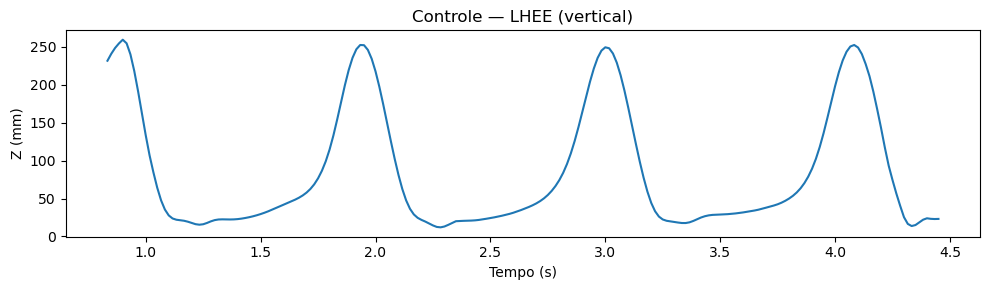

In [58]:
example_name = "Controle"
path = files[example_name]

t, labels, xyz, res, _ = load_vicon_mat(path)

print("Condição:", example_name)
print("Frames:", len(t), "| Marcadores:", len(labels))
print("Alguns labels:", labels[:12])

# Marcador (padrão: LHEE). Se não existir, troque para RHEE ou LANK etc.
marker = "LHEE"

mxyz = get_marker_xyz(labels, xyz, marker)
z = mxyz[:, 2]  # eixo Z (mm)

plt.figure(figsize=(10,3))
plt.plot(t, z)
plt.xlabel("Tempo (s)")
plt.ylabel("Z (mm)")
plt.title(f"{example_name} — {marker} (vertical)")
plt.tight_layout()
plt.show()


In [59]:
#from google.colab import drive
#drive.mount('/content/drive')

## 5) Detectar eventos de passo (proxy) e calcular métricas

fs (Hz): 60.0
N eventos: 4
{'n_events': 4, 'cadence_spm': 58.378378378378386, 'mean_event_interval_s': 1.0277777777777777, 'cv_interval_pct': 5.6949479745149745}


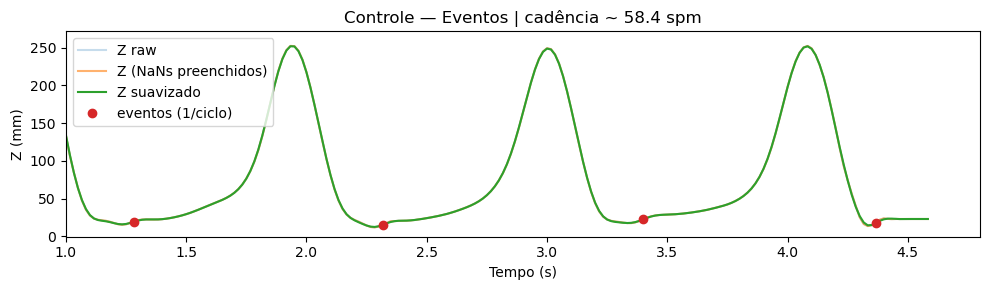

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

def fill_nans_1d(x):
    """Interpola NaNs em 1D (linear) e faz forward/backward fill nas bordas."""
    x = np.asarray(x, dtype=float)
    n = len(x)
    idx = np.arange(n)
    good = np.isfinite(x)

    if good.sum() < 2:
        # não tem dados suficientes para interpolar
        return x

    # interpola apenas nas regiões internas
    x_interp = x.copy()
    x_interp[~good] = np.interp(idx[~good], idx[good], x[good])

    return x_interp


def detect_events_from_vertical_velocity_one_per_cycle(
    t, z,
    min_step_time=0.35,
    smooth_window_s=0.15,
    prominence=10,      # deixe 10 para começar (se ficar ruidoso, aumente)
    cycle_window_s=0.8
):
    fs = 1 / np.mean(np.diff(t))
    min_dist = int(min_step_time * fs)

    # 1) preencher NaNs ANTES de qualquer coisa
    z_f = fill_nans_1d(z)

    # 2) suavização
    win = int(smooth_window_s * fs)
    win = max(win, 5)
    if win % 2 == 0:
        win += 1
    z_s = savgol_filter(z_f, window_length=win, polyorder=2)

    # 3) velocidade vertical
    vz = np.gradient(z_s, t)

    # 4) candidatos: picos positivos de vz
    cand, props = find_peaks(vz, distance=min_dist, prominence=prominence)
    if len(cand) == 0:
        return np.array([]), np.array([]), fs, z_s, vz, z_f

    # 5) 1 evento por ciclo: agrupar por janela e escolher menor Z
    cycle_window = int(cycle_window_s * fs)

    selected = []
    i = 0
    while i < len(cand):
        start = cand[i]
        end = start + cycle_window

        group = [cand[i]]
        j = i + 1
        while j < len(cand) and cand[j] <= end:
            group.append(cand[j])
            j += 1

        group = np.array(group, dtype=int)

        # agora z_s NÃO tem NaN → argmin funciona
        best = group[np.argmin(z_s[group])]
        selected.append(best)

        i = j

    peaks = np.array(selected, dtype=int)
    event_times = t[peaks]

    return peaks, event_times, fs, z_s, vz, z_f


def gait_metrics_from_events(event_times):
    intervals = np.diff(event_times)
    if len(intervals) < 2:
        return {
            "n_events": int(len(event_times)),
            "cadence_spm": np.nan,
            "mean_event_interval_s": np.nan,
            "cv_interval_pct": np.nan
        }
    cadence = 60.0 / np.mean(intervals)
    cv = 100 * np.std(intervals, ddof=1) / np.mean(intervals)
    return {
        "n_events": int(len(event_times)),
        "cadence_spm": float(cadence),
        "mean_event_interval_s": float(np.mean(intervals)),
        "cv_interval_pct": float(cv)
    }


# ===== TESTE NO EXEMPLO =====
marker = "LHEE"
mxyz = get_marker_xyz(labels, xyz, marker)
z = mxyz[:, 2]

peaks, event_times, fs, z_s, vz, z_f = detect_events_from_vertical_velocity_one_per_cycle(
    t, z,
    prominence=10,
    cycle_window_s=0.8
)

metrics = gait_metrics_from_events(event_times)

print("fs (Hz):", round(fs, 2))
print("N eventos:", len(event_times))
print(metrics)

plt.figure(figsize=(10,3))
plt.plot(t, z, label="Z raw", alpha=0.25)
plt.plot(t, z_f, label="Z (NaNs preenchidos)", alpha=0.6)
plt.plot(t, z_s, label="Z suavizado")
plt.plot(event_times, z_s[peaks], "o", label="eventos (1/ciclo)")
plt.xlim(1.0, 4.8)
plt.xlabel("Tempo (s)")
plt.ylabel("Z (mm)")
plt.title(f"{example_name} — Eventos | cadência ~ {metrics['cadence_spm']:.1f} spm")
plt.legend()
plt.tight_layout()
plt.show()


In [61]:
def filter_events_by_low_z_and_interval(t, peaks, z_s, z_low_pct=35, min_interval_s=0.6):
    """
    Mantém apenas eventos com:
    - Z baixo (<= percentil z_low_pct)
    - intervalo mínimo min_interval_s entre eventos
    """
    if peaks is None or len(peaks) == 0:
        return np.array([], dtype=int)

    peaks = np.array(peaks, dtype=int)

    # Filtro por Z baixo
    z_thresh = np.percentile(z_s[np.isfinite(z_s)], z_low_pct)
    keep = z_s[peaks] <= z_thresh
    peaks = peaks[keep]

    if len(peaks) == 0:
        return peaks

    # Filtro refratário
    kept = [peaks[0]]
    last_t = t[peaks[0]]
    for p in peaks[1:]:
        if (t[p] - last_t) >= min_interval_s:
            kept.append(p)
            last_t = t[p]

    return np.array(kept, dtype=int)


## 6) Rodar para todos os participantes e comparar em tabela

In [62]:
# ============================
# 6) Rodar para todos os participantes e comparar em tabela (AJUSTADO)
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "Files"
files = {
    "Controle": f"{base_dir}/Participante1_EO_N.mat",
    "PD_ON":    f"{base_dir}/Participante2_EO_N.mat",
    "PD_OFF":   f"{base_dir}/Participante3_EO_N.mat",
    "Ataxia":   f"{base_dir}/Participante4_EO_N.mat",
}

# --- Função de ajuste global: remove falsos positivos (pé alto) + eventos muito próximos ---
def filter_events_by_low_z_and_interval(t, peaks, z_s, z_low_pct=35, min_interval_s=0.6):
    """
    Mantém apenas eventos com:
    - Z baixo (<= percentil z_low_pct)
    - intervalo mínimo min_interval_s entre eventos
    """
    if peaks is None or len(peaks) == 0:
        return np.array([], dtype=int)

    peaks = np.array(peaks, dtype=int)

    # A) Filtro por Z baixo (percentil -> adapta por participante)
    z_valid = z_s[np.isfinite(z_s)]
    if len(z_valid) == 0:
        return np.array([], dtype=int)

    z_thresh = np.percentile(z_valid, z_low_pct)
    peaks = peaks[z_s[peaks] <= z_thresh]

    if len(peaks) == 0:
        return peaks

    # B) Filtro refratário (intervalo mínimo)
    kept = [peaks[0]]
    last_t = t[peaks[0]]
    for p in peaks[1:]:
        if (t[p] - last_t) >= min_interval_s:
            kept.append(p)
            last_t = t[p]

    return np.array(kept, dtype=int)


def choose_progression_axis_from_foot(xyz_marker):
    """Escolhe eixo de progressão (X ou Y) por maior amplitude."""
    xy = xyz_marker[:, :2]  # X,Y
    amp = np.nanmax(xy, axis=0) - np.nanmin(xy, axis=0)
    axis_idx = int(np.nanargmax(amp))
    axis_name = "X" if axis_idx == 0 else "Y"
    return axis_idx, axis_name


def stride_metrics_from_events_and_marker(t, xyz_marker, event_idx, axis_idx):
    """
    Métricas espaciais (mesmo pé) usando eventos detectados:
    - stride_length_m: deslocamento no eixo AP entre eventos do mesmo pé (m)
    - stride_time_s: tempo entre eventos (s)
    - speed_mps: stride_length / stride_time (m/s)
    """
    if event_idx is None or len(event_idx) < 3:
        return {"n_strides": 0, "stride_length_m": np.nan, "stride_time_s": np.nan, "speed_mps": np.nan}

    pos = xyz_marker[:, axis_idx] / 1000.0  # mm -> m
    pos_e = pos[event_idx]
    t_e = t[event_idx]

    dt = np.diff(t_e)
    dpos = np.diff(pos_e)

    stride_len = np.abs(dpos)
    speed = stride_len / dt

    return {
        "n_strides": int(len(stride_len)),
        "stride_length_m": float(np.nanmean(stride_len)),
        "stride_time_s": float(np.nanmean(dt)),
        "speed_mps": float(np.nanmean(speed)),
    }


def run_one(path, prefer_marker="LHEE", prominence=10, cycle_window_s=0.8,
            z_low_pct=35, min_interval_s=0.6):
    """
    Roda 1 arquivo:
    - detecta eventos (Passo 5)
    - aplica ajuste global (pé baixo + intervalo mínimo)
    - calcula métricas temporais e espaciais
    - retorna (out, pack) para usar no Passo 7
    """
    t, labels, xyz, res, _ = load_vicon_mat(path)

    marker = prefer_marker if prefer_marker in labels else (
        "RHEE" if "RHEE" in labels else None
    )

    if marker is None:
        out = {
            "marker": "NA",
            "fs_hz": float(1/np.mean(np.diff(t))),
            "axis": "NA",
            # temporais
            "n_events": 0,
            "cadence_spm": np.nan,
            "mean_event_interval_s": np.nan,
            "cv_interval_pct": np.nan,
            # espaciais
            "n_strides": 0,
            "stride_length_m": np.nan,
            "stride_time_s": np.nan,
            "speed_mps": np.nan
        }
        return out, None

    # Marcador e sinal
    mxyz = get_marker_xyz(labels, xyz, marker)   # Nx3
    z = mxyz[:, 2]

    # Detecção inicial (Passo 5)
    peaks, event_times, fs, z_s, vz, z_f = detect_events_from_vertical_velocity_one_per_cycle(
        t, z,
        prominence=prominence,
        cycle_window_s=cycle_window_s
    )

    # Ajuste global (remove falsos positivos)
    peaks = filter_events_by_low_z_and_interval(
        t, peaks, z_s,
        z_low_pct=z_low_pct,
        min_interval_s=min_interval_s
    )
    event_times = t[peaks]

    # Métricas temporais
    met_t = gait_metrics_from_events(event_times)

    # Métricas espaciais
    axis_idx, axis_name = choose_progression_axis_from_foot(mxyz)
    met_s = stride_metrics_from_events_and_marker(t, mxyz, peaks, axis_idx)

    out = {}
    out.update(met_t)
    out.update(met_s)
    out.update({
        "marker": marker,
        "fs_hz": float(fs),
        "axis": axis_name
    })

    # Pack para o Passo 7 (plots)
    pack = {
        "t": t.copy(),
        "mxyz": mxyz.copy(),
        "z_raw": z.copy(),
        "z_fill": z_f.copy(),
        "z_s": z_s.copy(),
        "vz": vz.copy(),
        "peaks": peaks.copy(),
        "event_times": event_times.copy(),
        "marker": marker,
        "axis": axis_name
    }

    return out, pack


# --------- Rodar todos e criar DF + PACKS ---------
results = {}
packs = {}

for name, path in files.items():
    met, pack = run_one(
        path,
        prefer_marker="LHEE",
        prominence=10,
        cycle_window_s=0.8,
        z_low_pct=35,
        min_interval_s=0.6
    )
    results[name] = met
    packs[name] = pack

df = pd.DataFrame(results).T
df


,n_events,cadence_spm,mean_event_interval_s,cv_interval_pct,n_strides,stride_length_m,stride_time_s,speed_mps,marker,fs_hz,axis
Controle,4,58.378378,1.027778,5.694948,3,1.305129,1.027778,1.270064,LHEE,60.0,X
PD_ON,3,56.692913,1.058333,10.021986,2,1.139232,1.058333,1.082163,LHEE,60.0,X
PD_OFF,4,50.46729,1.188889,9.121131,3,1.075427,1.188889,0.908719,LHEE,60.0,X
Ataxia,4,51.184834,1.172222,0.820877,3,1.044572,1.172222,0.890807,LHEE,60.0,X


6.4) Gráficos comparativos


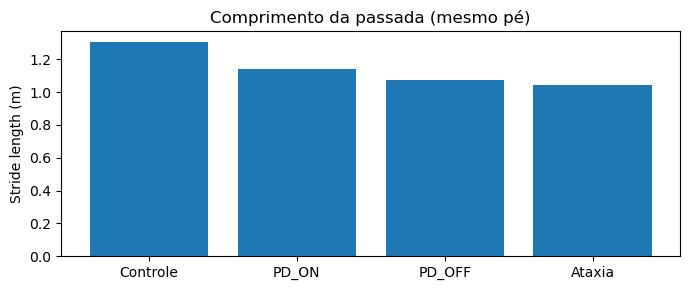

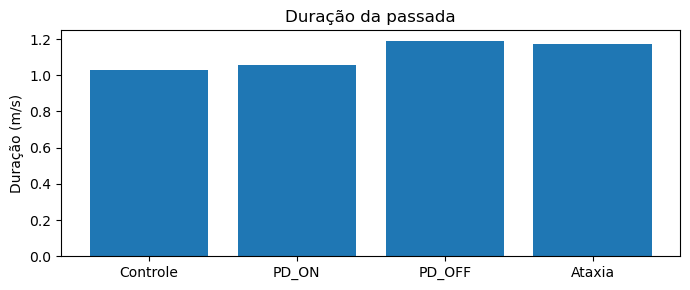

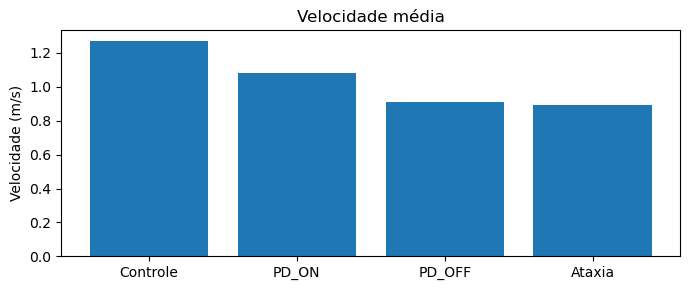

In [63]:
order = ["Controle", "PD_ON", "PD_OFF", "Ataxia"]
df_plot = df.loc[order]

plt.figure(figsize=(7,3))
plt.bar(df_plot.index, df_plot["stride_length_m"])
plt.ylabel("Stride length (m)")
plt.title("Comprimento da passada (mesmo pé)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.bar(df_plot.index, df_plot["stride_time_s"])
plt.ylabel("Duração (m/s)")
plt.title("Duração da passada")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.bar(df_plot.index, df_plot["speed_mps"])
plt.ylabel("Velocidade (m/s)")
plt.title("Velocidade média")
plt.tight_layout()
plt.show()


## 7) Comparar sinais (trecho inicial) e eventos

Controle  | z_s mean: 109.81215686037903  | z_s std: 91.63282104921664
PD_ON  | z_s mean: 80.99439192148502  | z_s std: 77.18590098561134
PD_OFF  | z_s mean: 92.02875096846721  | z_s std: 81.53004846342156
Ataxia  | z_s mean: 60.55813778805321  | z_s std: 62.49381699129882


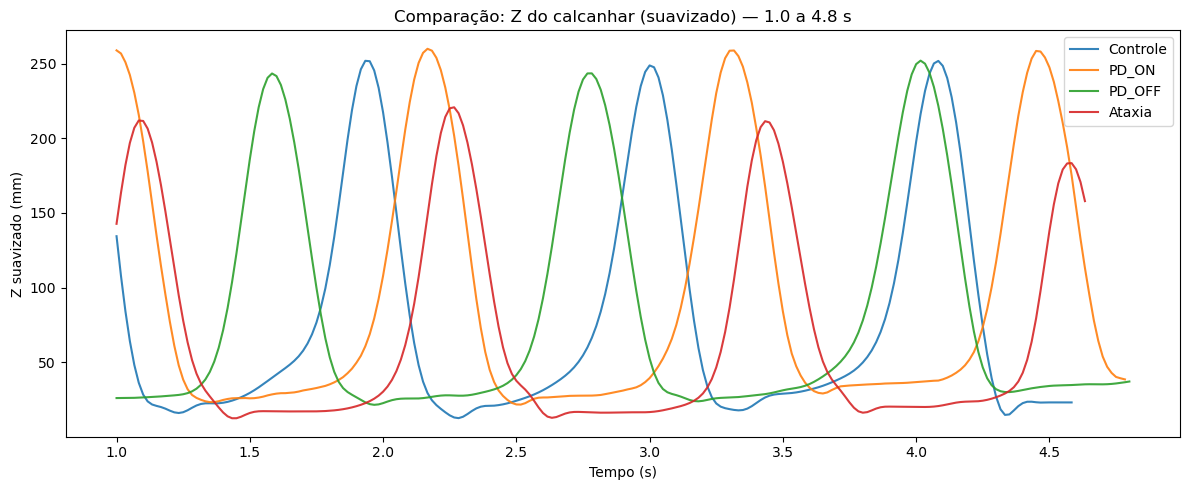

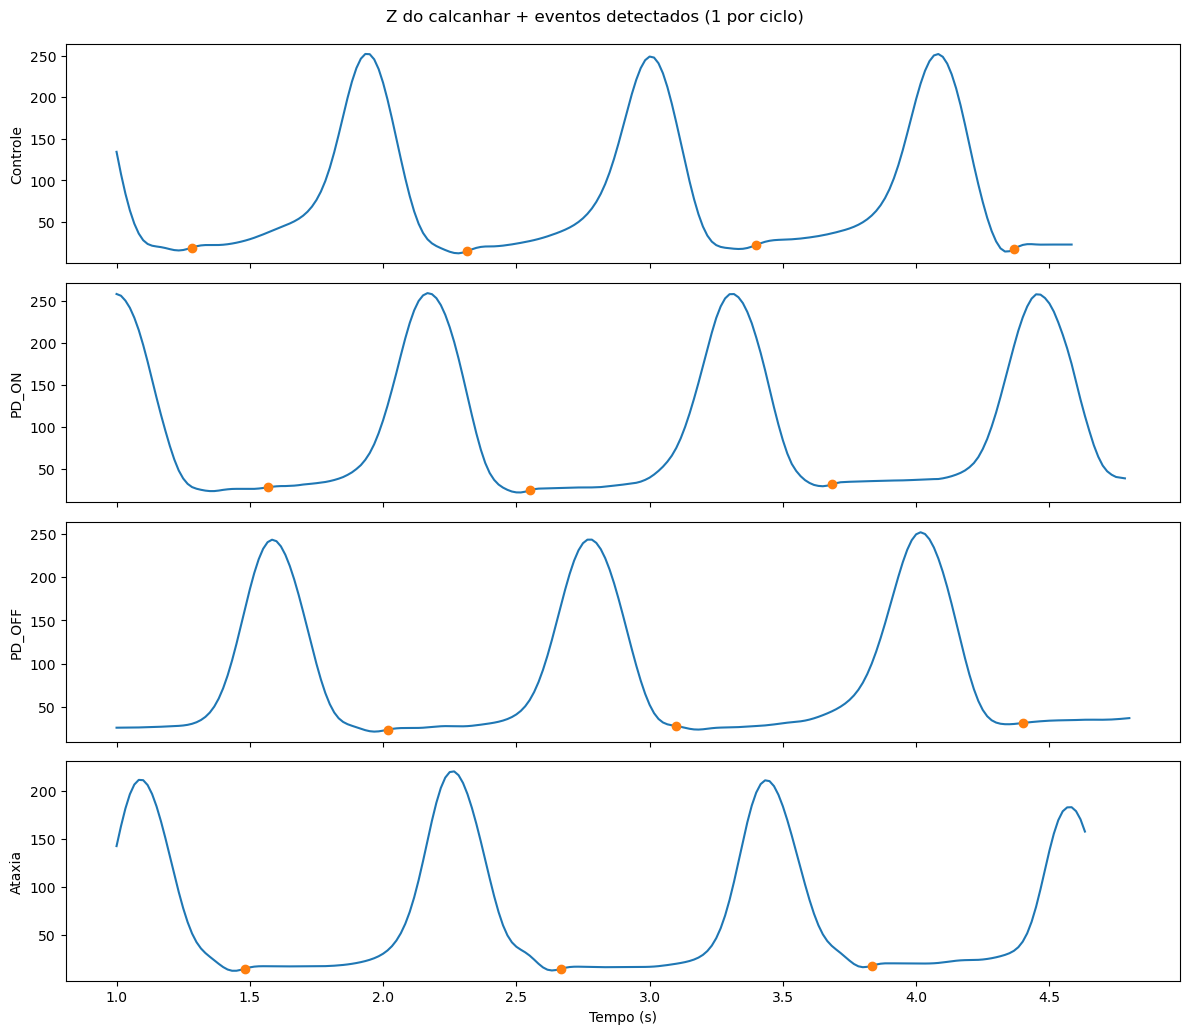

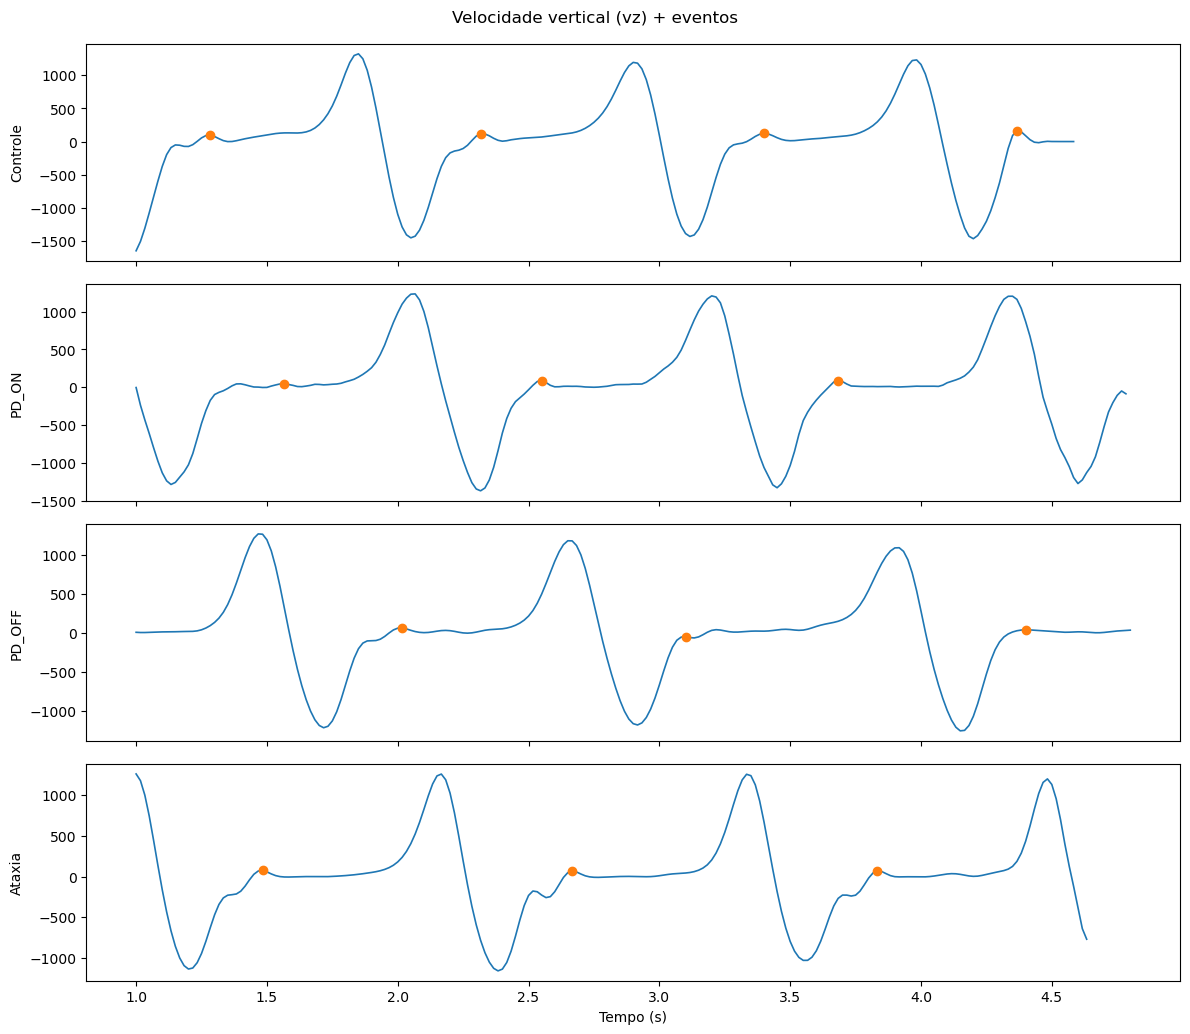

In [64]:
import numpy as np
import matplotlib.pyplot as plt

order = ["Controle", "PD_ON", "PD_OFF", "Ataxia"]
for name in ["Controle", "PD_ON", "PD_OFF", "Ataxia"]:
    pack = packs[name]
    print(
        name,
        " | z_s mean:", np.mean(pack["z_s"]),
        " | z_s std:",  np.std(pack["z_s"])
    )


# ajuste o zoom aqui
tmin = 1.0
tmax = 4.8

# =========================
# 7.1) Z suavizado (todos juntos)
# =========================
plt.figure(figsize=(12,5))
for name in order:
    pack = packs.get(name, None)
    if pack is None:
        continue

    t = pack["t"]
    z_s = pack["z_s"]

    mask = (t >= tmin) & (t <= tmax)
    plt.plot(t[mask], z_s[mask], label=name, alpha=0.9)

plt.xlabel("Tempo (s)")
plt.ylabel("Z suavizado (mm)")
plt.title(f"Comparação: Z do calcanhar (suavizado) — {tmin:.1f} a {tmax:.1f} s")
plt.legend()
plt.tight_layout()
plt.show()


# =========================
# 7.2) Painel: Z + eventos por participante
# =========================
fig, axes = plt.subplots(len(order), 1, figsize=(12, 2.6*len(order)), sharex=True)

for ax, name in zip(axes, order):
    pack = packs.get(name, None)
    if pack is None:
        ax.set_ylabel(name)
        ax.text(0.02, 0.5, "Sem dados", transform=ax.transAxes)
        continue

    t = pack["t"]
    z_s = pack["z_s"]
    peaks = pack["peaks"]

    mask = (t >= tmin) & (t <= tmax)
    ax.plot(t[mask], z_s[mask], lw=1.5)

    # eventos dentro da janela
    if peaks is not None and len(peaks) > 0:
        p = peaks[(t[peaks] >= tmin) & (t[peaks] <= tmax)]
        ax.plot(t[p], z_s[p], "o")

    ax.set_ylabel(name)

axes[-1].set_xlabel("Tempo (s)")
fig.suptitle("Z do calcanhar + eventos detectados (1 por ciclo)", y=0.99)
plt.tight_layout()
plt.show()


# =========================
# 7.3) (Opcional) Painel: vz + eventos por participante
# =========================
fig, axes = plt.subplots(len(order), 1, figsize=(12, 2.6*len(order)), sharex=True)

for ax, name in zip(axes, order):
    pack = packs.get(name, None)
    if pack is None:
        ax.set_ylabel(name)
        ax.text(0.02, 0.5, "Sem dados", transform=ax.transAxes)
        continue

    t = pack["t"]
    vz = pack["vz"]
    peaks = pack["peaks"]

    mask = (t >= tmin) & (t <= tmax)
    ax.plot(t[mask], vz[mask], lw=1.2)

    if peaks is not None and len(peaks) > 0:
        p = peaks[(t[peaks] >= tmin) & (t[peaks] <= tmax)]
        ax.plot(t[p], vz[p], "o")

    ax.set_ylabel(name)

axes[-1].set_xlabel("Tempo (s)")
fig.suptitle("Velocidade vertical (vz) + eventos", y=0.99)
plt.tight_layout()
plt.show()



## 9) Perguntas para discussão (2–5 min)
1. Quais condições mostram maior **variabilidade**? Isso aparece no sinal?
2. A cadência muda entre PD_ON e PD_OFF? A variabilidade muda?
3. O que este **proxy** NÃO captura (ex.: comprimento de passo real, assimetria, eventos precisos)?

